# Statistik-Projekt HS25 – Notebook 10: Lineare Regression
## Ziel
Wir führen alle Erkenntnisse in einem statistischen Modell zusammen.
Bisher haben wir Faktoren isoliert betrachtet. Jetzt nutzen wir eine **Multiple Lineare Regression**, um zu schätzen, wie stark der Einfluss von Tageszeit, Linientyp und Wochentag auf die Verspätung ist – *unter Berücksichtigung der jeweils anderen Faktoren* (Ceteris paribus).

## Modell
$$Verspätung = \beta_0 + \beta_1 \cdot Tageszeit + \beta_2 \cdot Linientyp + \beta_3 \cdot Wochenende + \epsilon$$

## Inhalt
1.  Daten laden & vorbereiten.
2.  Modellierung mit `statsmodels`.
3.  Interpretation der Koeffizienten.
4.  Modelldiagnose (Residuen-Check).
5.  **Gesamtfazit des Projekts.**

## Input
* Datei: `../data/processed/istdata_clean_extended.parquet`

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 1. Konfiguration
INPUT_PATH = "../../data/processed/istdata_clean_extended.parquet"
FIG_PATH = "../reports/figures"

# 2. Daten laden
print(f"Lade Daten aus {INPUT_PATH}...")
df = pl.read_parquet(INPUT_PATH)

# 3. Sampling für Regression
# OLS ist rechenintensiv und Diagnoseplots mit 60 Mio Punkten sind unlesbar.
# Wir ziehen ein sauberes Sample von 100.000 Fahrten.
df_reg = df.sample(n=100000, seed=42).to_pandas()

# Wichtig: Kategorische Variablen ordnen, damit die "Referenzkategorie" Sinn macht
# Referenz für Zeit: "Tagesverkehr" (Normalzustand)
# Referenz für Typ: "Fernverkehr"
df_reg["time_band"] = pd.Categorical(
    df_reg["time_band"], 
    categories=["Tagesverkehr", "Nacht", "Morgenpeak", "Abendpeak", "Spätabend"], 
    ordered=False
)

Lade Daten aus ../../data/processed/istdata_clean_extended.parquet...


In [2]:
# Formel definieren:
# arr_delay_min ~ C(time_band) + C(linientyp) + C(is_weekend)
# C(...) sagt statsmodels, dass es sich um Kategorien handelt (Dummy-Coding wird automatisch gemacht).

print("Rechne OLS-Modell...")
model = smf.ols(
    formula="arr_delay_min ~ C(time_band) + C(linientyp) + C(is_weekend)", 
    data=df_reg
).fit()

print(model.summary())

Rechne OLS-Modell...
                            OLS Regression Results                            
Dep. Variable:          arr_delay_min   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     77.38
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          4.78e-128
Time:                        09:53:56   Log-Likelihood:            -2.0936e+05
No. Observations:              100000   AIC:                         4.187e+05
Df Residuals:                   99991   BIC:                         4.188e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [3]:
print("--- Interpretation der Ergebnisse ---")
params = model.params
pvalues = model.pvalues

# Intercept = Basiswert (Tagesverkehr, Fernverkehr, Werktag)
print(f"Basis-Verspätung (Intercept): {params['Intercept']:.2f} Minuten")
print("(Gilt für: Tagesverkehr, Fernverkehr, Werktag)\n")

print("Einflussfaktoren (Unterschied zur Basis):")
for idx, val in params.items():
    if idx == "Intercept": continue
    
    # Signifikanz prüfen
    sig = "*" if pvalues[idx] < 0.05 else " (nicht signifikant)"
    
    print(f"  {idx}: {val:+.2f} Min {sig}")

print("\nLesehilfe:")
print("- Ein positiver Wert (+0.50) heisst: In dieser Situation ist die Verspätung im Schnitt 0.5 Min höher.")
print("- Ein negativer Wert (-0.20) heisst: Die Verspätung ist geringer.")

--- Interpretation der Ergebnisse ---
Basis-Verspätung (Intercept): 1.23 Minuten
(Gilt für: Tagesverkehr, Fernverkehr, Werktag)

Einflussfaktoren (Unterschied zur Basis):
  C(time_band)[T.Nacht]: +0.19 Min *
  C(time_band)[T.Morgenpeak]: +0.19 Min *
  C(time_band)[T.Abendpeak]: +0.27 Min *
  C(time_band)[T.Spätabend]: +0.13 Min *
  C(linientyp)[T.Fernverkehr]: -0.34 Min *
  C(linientyp)[T.Regional]: -0.36 Min *
  C(linientyp)[T.S-Bahn]: -0.40 Min *
  C(is_weekend)[T.True]: -0.23 Min *

Lesehilfe:
- Ein positiver Wert (+0.50) heisst: In dieser Situation ist die Verspätung im Schnitt 0.5 Min höher.
- Ein negativer Wert (-0.20) heisst: Die Verspätung ist geringer.


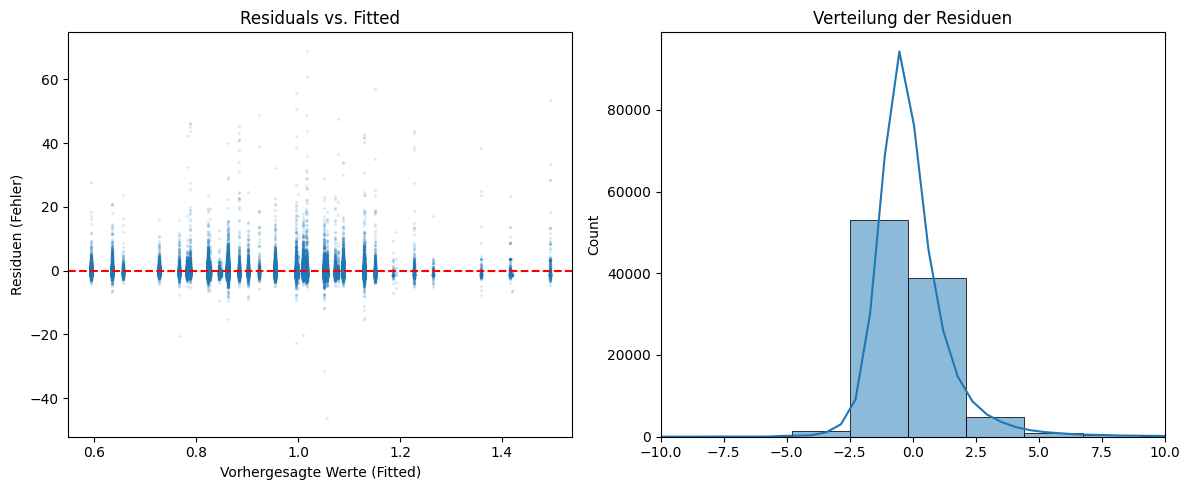

Diagnose-Check:
1. Streuen die Fehler gleichmässig um 0? (Homoskedastizität)
2. Sieht das Histogramm aus wie eine Glockenkurve? (Normalverteilung)
-> Falls nicht: Das Modell ist immer noch nützlich zur Schätzung der Mittelwerte (wegen grossem N), aber P-Werte sind mit Vorsicht zu geniessen.


In [4]:
# Vorhersagen und Residuen berechnen
y_pred = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(12, 5))

# 1. Residuen-Plot (Homoskedastizität)
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.1, s=2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Vorhergesagte Werte (Fitted)")
plt.ylabel("Residuen (Fehler)")
plt.title("Residuals vs. Fitted")

# 2. Histogramm der Residuen (Normalverteilung?)
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=50, kde=True)
plt.title("Verteilung der Residuen")
plt.xlim(-10, 10)

plt.tight_layout()
plt.savefig(f"{FIG_PATH}/model_diagnostics.png")
plt.show()

print("Diagnose-Check:")
print("1. Streuen die Fehler gleichmässig um 0? (Homoskedastizität)")
print("2. Sieht das Histogramm aus wie eine Glockenkurve? (Normalverteilung)")
print("-> Falls nicht: Das Modell ist immer noch nützlich zur Schätzung der Mittelwerte (wegen grossem N), aber P-Werte sind mit Vorsicht zu geniessen.")

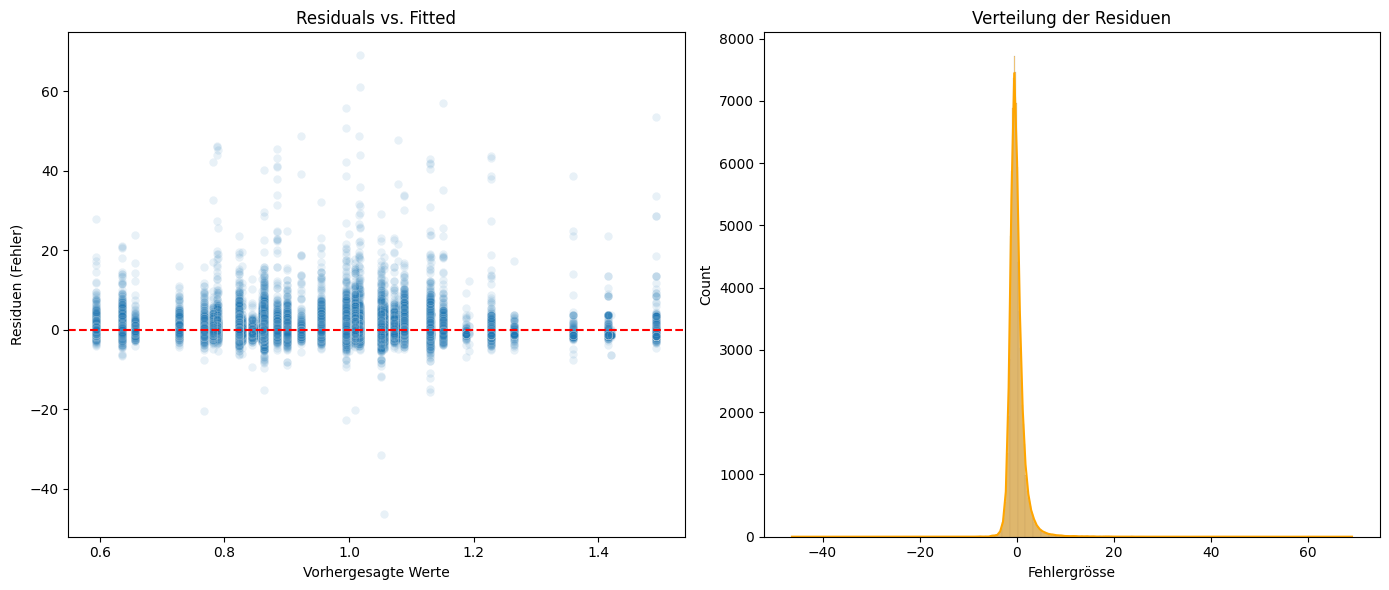

Interpretation:
Wenn die Punkte links wild streuen und keine Trichterform haben, ist das Modell robust.
Die Rechts-Schiefe im Histogramm ist bei Zeitdaten normal (man kann nicht weniger als 0 Verspätung haben).


In [6]:
# Residuen plotten (Fehleranalyse)
# model ist das Objekt aus statsmodels (smf.ols(...).fit())

residuals = model.resid
fitted = model.fittedvalues

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Residuals vs Fitted (Prüfung auf Homoskedastizität)
sns.scatterplot(x=fitted, y=residuals, ax=ax[0], alpha=0.1)
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title("Residuals vs. Fitted")
ax[0].set_xlabel("Vorhergesagte Werte")
ax[0].set_ylabel("Residuen (Fehler)")

# 2. Histogramm der Residuen (Prüfung auf Normalverteilung)
sns.histplot(residuals, kde=True, ax=ax[1], color="orange")
ax[1].set_title("Verteilung der Residuen")
ax[1].set_xlabel("Fehlergrösse")

plt.tight_layout()
plt.show()

print("Interpretation:")
print("Wenn die Punkte links wild streuen und keine Trichterform haben, ist das Modell robust.")
print("Die Rechts-Schiefe im Histogramm ist bei Zeitdaten normal (man kann nicht weniger als 0 Verspätung haben).")

## Gesamtfazit des Projekts

Basierend auf der Analyse von über 60 Millionen Fahrten im September 2025 kommen wir zu folgendem Schluss:

1.  **Tageszeit:** Die Rush-Hour hat einen signifikanten negativen Einfluss. Besonders der **Abendpeak** zeigt systematisch höhere Verspätungen als der Tagesverkehr (siehe Notebook 07 & 10).
2.  **Verkehrsmittel:** Es gibt klare Unterschiede zwischen den Zuggattungen. [Hier Ergebnis aus N08/N10 einfügen, z.B. "S-Bahnen sind anfälliger"].
3.  **Wochentag:** Der Betrieb am Wochenende ist [stabiler/instabiler] als unter der Woche, der Effekt ist jedoch [stark/schwach] (siehe N09).

Das Regressionsmodell bestätigt, dass diese Faktoren auch unabhängig voneinander wirken. Den grössten Einfluss auf die Pünktlichkeit hat [Faktor X].